In [1]:
import os
import sys

script_path = os.path.join(os.getcwd(), "../../Scripts/")
sys.path.append(script_path)
import data_generator as dgen


import matplotlib.pyplot as plt
from datetime import datetime

import torch
import numpy as np
import yaml
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay,
    confusion_matrix,
)
from sklearn.metrics import recall_score, accuracy_score, precision_score

import mlflow
from clearml import Task, Logger

# Создаем таску в clearML

In [2]:
import uuid

run_name = f"Run-{uuid.uuid4().hex[:8]}"

task = Task.init(
    project_name="Diploma Multibranch net",
    task_name=run_name,
    task_type=Task.TaskTypes.training,
)

task.set_system_tags(["gpu_monitoring"])

ClearML Task: created new task id=f369df59117a41ee990502bae10aad10
2024-11-24 14:53:34,760 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/fb3fda3d43384b2d8e49fef268418091/experiments/f369df59117a41ee990502bae10aad10/output/log


In [3]:
class ECGDataAugmentation:
    def __init__(self, noise_level=0.01, shift_range=0.1, mask_prob=0.1):
        """
        Аргументы:
        noise_level (float): Уровень шума, добавляемого к сигналу.
        shift_range (float): Максимальный сдвиг сигнала, выраженный в доле от длины.
        mask_prob (float): Вероятность маскирования случайных интервалов.
        """
        self.noise_level = noise_level
        self.shift_range = shift_range
        self.mask_prob = mask_prob

    def add_noise(self, signal):
        """Добавляем гауссовский шум к сигналу."""
        noise = torch.randn_like(signal) * self.noise_level
        return signal + noise

    def shift_signal(self, signal):
        """Сдвигаем сигнал на случайное значение в пределах shift_range."""
        shift_amount = int(self.shift_range * signal.size(-1))
        shift = np.random.randint(-shift_amount, shift_amount)
        return torch.roll(signal, shifts=shift, dims=-1)

    def mask_random_intervals(self, signal):
        """Маскируем случайные интервалы в сигнале, заменяя их на нули."""
        mask = torch.rand(signal.size()) < self.mask_prob
        signal = signal.masked_fill(mask, 0)
        return signal

    def __call__(self, signal):
        """Применяем все аугментации."""
        signal = self.add_noise(signal)
        signal = self.shift_signal(signal)
        signal = self.mask_random_intervals(signal)
        return signal


data_augmentation = ECGDataAugmentation(
    noise_level=0.01, shift_range=0.1, mask_prob=0.1
)

In [ ]:
# Примерная функция для нормализации
def normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)


# Класс для подготовки датасета
class ECGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.fixed_length = 5000  # Пример длины для padding

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Берем данные пациента
        ecg_signal = self.data[idx]

        # Применяем нормализацию к каждому каналу
        ecg_signal = np.array([normalize(ch) for ch in ecg_signal])

        # Padding/Truncation до фиксированной длины
        ecg_signal = self._fix_length(ecg_signal)

        # Преобразование в torch.tensor
        ecg_signal = torch.tensor(ecg_signal, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return ecg_signal, label

    def _fix_length(self, ecg_signal):
        # Применяем padding или обрезание
        if ecg_signal.shape[1] < self.fixed_length:
            pad_size = self.fixed_length - ecg_signal.shape[1]
            ecg_signal = np.pad(ecg_signal, ((0, 0), (0, pad_size)), "constant")
        else:
            ecg_signal = ecg_signal[:, : self.fixed_length]
        return ecg_signal


def create_weighted_sampler(labels):
    class_counts = torch.bincount(labels)
    class_weights = 1.0 / class_counts.float()
    sample_weights = class_weights[labels]
    sampler = WeightedRandomSampler(
        weights=sample_weights, num_samples=len(labels), replacement=True
    )
    return sampler


import pickle

with open("../../Data/dumped/X_train.pkl", "rb") as f:
    f.seek(0)
    X_train = pickle.load(f)
with open("../../Data/dumped/y_train.pkl", "rb") as f:
    f.seek(0)
    y_train = pickle.load(f)
with open("../../Data/dumped/X_test.pkl", "rb") as f:
    f.seek(0)
    X_test = pickle.load(f)
with open("../../Data/dumped/y_test.pkl", "rb") as f:
    f.seek(0)
    y_test = pickle.load(f)

print(X_train.shape)
print(y_train.shape)
y_train = np.concatenate([y_train, y_train], axis=1)
Y_train = y_train[0].astype("int8")
Y_test = y_test[0].astype("int8")
# Y_train = F.one_hot(torch.LongTensor(y_train[0]), num_classes=2).double()
# Y_train.double()
# Y_test = F.one_hot(torch.LongTensor(y_test[0]), num_classes=2).double()
# Y_test.double()
# Y_train = y_train[0]
# Y_test = y_test[0]


X_train = np.concatenate(
    [X_train, np.array([data_augmentation(torch.tensor(x)).numpy() for x in X_train])],
    axis=0,
)
print(X_train.shape)
print(y_train.shape)

sampler = create_weighted_sampler(torch.LongTensor(Y_train))
train_dataset = ECGDataset(data=X_train, labels=Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
# train_loader = DataLoader(train_dataset, batch_size=32)

test_dataset = ECGDataset(data=X_test, labels=Y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

(190, 8, 5000)
(2, 190)
(380, 8, 5000)
(2, 380)


# Генерируем yaml

In [6]:
import yaml

unique_train, counts_train = np.unique(Y_train, return_counts=True)
unique_test, counts_test = np.unique(Y_test, return_counts=True)
train_dict = dict(zip(unique_train, counts_train))
test_dict = dict(zip(unique_test, counts_test))

# Определяем конфигурацию
config = {
    "model": {
        "architecture": "MultiBranchECGNet",
        "num_channels": 8,
        "num_classes": 2,
        "parameters": {"learning_rate": 0.001, "dropout_rate": 0.1},
    },
    "optimizer": {"type": "Adam", "parameters": {"lr": 0.001, "weight_decay": 1e-5}},
    "loss_function": {
        "type": "FocalLoss",
        "parameters": {"alpha": 1.0, "gamma": 1, "pos_weight": [1, 3]},
    },
    "dataset": {
        "train_size": len(train_dataset),
        "test_size": len(test_dataset),
        "class_distribution": {
            "train": {0 : int(train_dict[0]), 1: int(train_dict[1])},
            "test": {0 : int(test_dict[0]), 1: int(test_dict[1])},
        },
    },
}

# Сохраняем в файл
with open("config.yaml", "w") as f:
    yaml.dump(config, f)


In [7]:
import torch.nn as nn


class ECGNet(nn.Module):
    def __init__(self):
        super(ECGNet, self).__init__()

        # Сверточные слои
        self.conv1 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=7, padding=3)
        self.conv2 = nn.Conv1d(
            in_channels=16, out_channels=32, kernel_size=5, padding=2
        )
        self.pool = nn.MaxPool1d(kernel_size=2)

        # LSTM слой для захвата временных зависимостей
        self.lstm = nn.LSTM(
            input_size=32,
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
        )

        # Полносвязные слои
        self.fc1 = nn.Linear(64 * 2, 128)
        self.fc2 = nn.Linear(128, 3)  # Предполагается 3 класса болезней

    def forward(self, x):
        # x shape: [batch_size, 8, seq_len]

        # Свертка
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        # Подготовка для LSTM
        # Меняем размер на [batch_size, seq_len, channels] для LSTM
        x = x.permute(0, 2, 1)

        # LSTM
        x, (hn, cn) = self.lstm(x)

        # Берем последнее скрытое состояние LSTM
        x = x[:, -1, :]  # [batch_size, 64*2]

        # Полносвязные слои
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # [batch_size, num_classes]

        return x

In [8]:
class MultiBranchECGNet(nn.Module):
    def __init__(self, num_channels=8, num_classes=3):
        super(MultiBranchECGNet, self).__init__()

        # Ветви для каждого канала (CNN)
        self.branches = nn.ModuleList(
            [self.create_branch() for _ in range(num_channels)]
        )

        # Attention слой для агрегации информации между каналами
        self.attention = nn.MultiheadAttention(
            embed_dim=128, num_heads=8, batch_first=True
        )

        # Линейный слой для выравнивания размерности перед attention
        self.linear_attn = nn.Linear(num_channels * 128, 128)

        # Полносвязные слои для классификации
        self.fc1 = nn.Linear(128, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.drop = nn.Dropout(p=config["model"]["parameters"]["dropout_rate"])

    def create_branch(self):
        """Создаем сверточную ветвь для каждого канала"""
        branch = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),  # Свертка с padding
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),  # Вторая сверточная операция
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),  # Третья сверточная операция
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        return branch

    def forward(self, x):
        # x shape: [batch_size, num_channels, seq_len]

        # Обрабатываем каждый канал через свою ветвь (CNN для каждого канала)
        branch_outputs = []
        for i in range(x.size(1)):  # num_channels
            branch_output = self.branches[i](
                x[:, i : i + 1, :]
            )  # Обрабатываем i-й канал, [batch_size, 1, seq_len]
            branch_outputs.append(branch_output)

        # Объединяем выходы ветвей
        out = torch.stack(
            branch_outputs, dim=1
        )  # [batch_size, num_channels, 128, reduced_seq_len]

        # out = out.mean(dim=-1)  # Усредняем по временной оси: [batch_size, num_channels, 128]

        # # Применяем multi-head attention для межканальной агрегации
        # out, _ = self.attention(out, out, out)  # [batch_size, num_channels, 128]

        # # Flatten the output
        # out = torch.flatten(out, start_dim=1, end_dim=2)  # [batch_size, num_channels * 128]

        # Меняем форму, чтобы соответствовать входу MultiheadAttention: [batch_size, reduced_seq_len, num_channels * 128]
        batch_size, num_channels, embed_dim, seq_len = out.shape
        out = out.permute(0, 3, 1, 2).reshape(batch_size, seq_len, -1)

        out = F.relu(self.linear_attn(out))

        # Применяем Multihead Attention ко всей последовательности
        out, _ = self.attention(
            out, out, out
        )  # [batch_size, seq_len, num_channels * 128]

        # Усредняем по временной оси
        out = out.mean(dim=1)  # [batch_size, num_channels * 128]

        # Полносвязные слои для классификации
        out = F.relu(self.drop(self.fc1(out)))
        out = self.fc2(out)  # [batch_size, num_classes]
        return out


# Пример использования
model = MultiBranchECGNet(num_channels=8, num_classes=2)

In [9]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss

In [10]:
mlflow.start_run()

<ActiveRun: >

In [11]:
loss_type = config["loss_function"]["type"]

if loss_type == "FocalLoss":
    criterion = FocalLoss(
        alpha=config["loss_function"]["parameters"]["alpha"],
        gamma=config["loss_function"]["parameters"]["gamma"],
    )
elif loss_type == "BCEWithLogitsLoss":
    pos_weight = torch.tensor(config["loss_function"]["parameters"]["pos_weight"])
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
    raise ValueError(f"Unknown loss function type: {loss_type}")

# criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = FocalLoss(alpha=2, gamma=3)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=config["optimizer"]["parameters"]["lr"],
    weight_decay=config["optimizer"]["parameters"]["weight_decay"],
)


# Обучение модели
def train_model(model, dataloader, criterion, optimizer, num_epochs=10, patience=10):
    best_valid_loss = float("inf")
    patience_counter = 0

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        all_preds = []
        all_labels = []

        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            # labels.type(torch.FloatTensor)

            # labels = labels.type(torch.FloatTensor) \
            #   .reshape((labels.shape[0], 2))epoch_loss

            labels = F.one_hot(labels, num_classes=2).float()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            all_preds.extend(torch.argmax(outputs, dim=1))
            all_labels.extend(torch.argmax(labels, dim=1))

        epoch_loss = running_loss / len(dataloader.dataset)
        recall = recall_score(all_labels, all_preds)
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds)

        Logger.current_logger().report_scalar("Accuracy", "Train", accuracy, epoch)
        Logger.current_logger().report_scalar("Loss", "Train", epoch_loss, epoch)
        Logger.current_logger().report_scalar("Recall", "Train", recall, epoch)
        Logger.current_logger().report_scalar("Precision", "Train", precision, epoch)

        mlflow.log_metric("Train Accuracy", accuracy, step=epoch)
        mlflow.log_metric("Train Loss", epoch_loss, step=epoch)
        mlflow.log_metric("Train Recall", recall, step=epoch)
        mlflow.log_metric("Train Precision", precision, step=epoch)
        
        if abs(epoch_loss - best_valid_loss) > 0.001:
            best_valid_loss = epoch_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

        # if epoch_loss < best_valid_loss:
        #     best_valid_loss = epoch_loss
        #     print(f"\nBest validation loss: {best_valid_loss}")
        #     print(f"\nSaving best model for epoch: {epoch+1}\n")
        #     torch.save(model.state_dict(), "model_weights.pth")
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")


# Запуск обучения
train_model(model, train_loader, criterion, optimizer, num_epochs=50)

Epoch 1/50, Loss: 0.3385


/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Epoch 2/50, Loss: 0.3141
Epoch 3/50, Loss: 0.2928
Epoch 4/50, Loss: 0.2659
Epoch 5/50, Loss: 0.2317
Epoch 6/50, Loss: 0.2314
Epoch 7/50, Loss: 0.2276
Epoch 8/50, Loss: 0.1775
Epoch 9/50, Loss: 0.1879
Epoch 10/50, Loss: 0.1769
Epoch 11/50, Loss: 0.1475
Epoch 12/50, Loss: 0.1343
Epoch 13/50, Loss: 0.1918
Epoch 14/50, Loss: 0.1394
Epoch 15/50, Loss: 0.1268
Epoch 16/50, Loss: 0.1009
Epoch 17/50, Loss: 0.0892
Epoch 18/50, Loss: 0.0624
Epoch 19/50, Loss: 0.0657
Epoch 20/50, Loss: 0.0582
Epoch 21/50, Loss: 0.0676
Epoch 22/50, Loss: 0.0784
Epoch 23/50, Loss: 0.0559
Epoch 24/50, Loss: 0.0478
Epoch 25/50, Loss: 0.0322
Epoch 26/50, Loss: 0.1175
Epoch 27/50, Loss: 0.0859
Epoch 28/50, Loss: 0.0617
Epoch 29/50, Loss: 0.0376
Epoch 30/50, Loss: 0.0324
Epoch 31/50, Loss: 0.0180
Epoch 32/50, Loss: 0.0192
Epoch 33/50, Loss: 0.0095
Epoch 34/50, Loss: 0.0058
Epoch 35/50, Loss: 0.0134
Epoch 36/50, Loss: 0.0415
Epoch 37/50, Loss: 0.0257
Epoch 38/50, Loss: 0.0172
Epoch 39/50, Loss: 0.0124
Epoch 40/50, Loss: 0

In [12]:
# Сохранение модели
torch.save(model.state_dict(), "model_weights.pth")
task.upload_artifact(name="Model Weights", artifact_object="model_weights.pth")

# Сохранение конфигурации
task.upload_artifact(name="Config File", artifact_object="config.yaml")

2024-11-24 15:07:10,701 - clearml.frameworks - INFO - Found existing registered model id=078a530219b44bd5b8f841b1a246c02b [/home/kravchenko.artem/Projects/Diplomas/Classifiers/NN/model_weights.pth] reusing it.


True

Validation recall: 0.6250
Validation accuracy: 0.7917
Validation precision: 0.4167

 clasification report:
               precision    recall  f1-score   support

           0       0.92      0.82      0.87        40
           1       0.42      0.62      0.50         8

    accuracy                           0.79        48
   macro avg       0.67      0.72      0.68        48
weighted avg       0.83      0.79      0.81        48

Матрица несоответствий для тестовой выборки метода ЛДА:



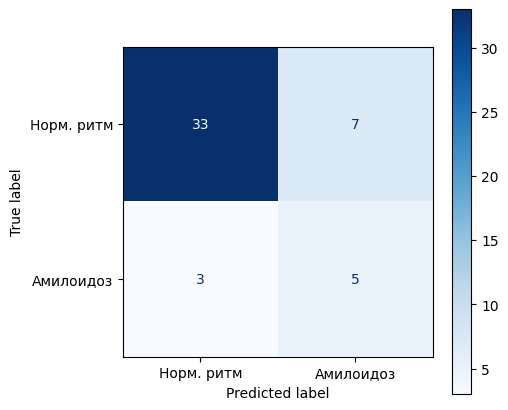

In [13]:
def validate_model(model, dataloader):
    model = MultiBranchECGNet(num_channels=8, num_classes=2)
    model.load_state_dict(torch.load("model_weights.pth", weights_only=True))
    model.eval()  # Переводим модель в режим оценки
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Отключаем градиенты для валидации
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Предсказания с максимальной вероятностью
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Преобразуем в numpy массивы
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    # all_labels = np.argmax(all_labels, axis=1)

    # Считаем accuracy
    recall = recall_score(all_labels, all_preds)
    print(f"Validation recall: {recall:.4f}")
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Validation accuracy: {accuracy:.4f}")
    precision = precision_score(all_labels, all_preds)
    print(f"Validation precision: {precision:.4f}")

    class_names = ["Норм. ритм", "Амилоидоз"]

    print("\n clasification report:\n", classification_report(all_labels, all_preds))

    print("Матрица несоответствий для тестовой выборки метода ЛДА:\n")
    fig, ax = plt.subplots(figsize=(5, 5))
    disp = ConfusionMatrixDisplay(
        confusion_matrix(all_labels, all_preds), display_labels=class_names
    )
    disp.plot(cmap="Blues", ax=ax)

    Logger.current_logger().report_confusion_matrix(
        title="Confusion Matrix",
        series="Validation Results",
        matrix=confusion_matrix(all_labels, all_preds),
        yaxis_reversed=True,
        xaxis="Predicted",
        yaxis="Expected",
        xlabels=class_names,
        ylabels=class_names
    )

    return recall


# Пример вызова валидации
test_accuracy = validate_model(model, test_loader)

In [14]:
mlflow.end_run()
task.close()